In [ ]:
!pip install pmdarima

In [ ]:
from statistics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/content/BigML_Dataset_5f50a4cc0d052e40e6000034.csv")
df

,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
0,245,2008,9,1,1,False,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,245,2008,9,1,4,False,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,243,2009,8,31,10,True,0.166453,63,27,13.9,4,10.0,75,10.0,29.93,6995
2916,243,2009,8,31,13,True,0.064020,63,27,13.9,1,10.0,66,15.0,29.91,29490
2917,243,2009,8,31,16,True,0.294494,63,27,13.9,2,10.0,68,21.0,29.88,17257
2918,243,2009,8,31,19,True,0.524968,63,27,13.9,2,10.0,81,17.0,29.87,677


In [ ]:
df['First Hour of Period'] = df['First Hour of Period'].where(df['First Hour of Period'] != 1)
df['First Hour of Period'] = df['First Hour of Period'].where(df['First Hour of Period'] != 4)
df['First Hour of Period'] = df['First Hour of Period'].where(df['First Hour of Period'] != 22)
df = df.dropna()
df.reset_index(inplace=True,drop=True)
df

,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
0,245,2008,9,1,7.0,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
1,245,2008,9,1,10.0,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
2,245,2008,9,1,13.0,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069
3,245,2008,9,1,16.0,True,0.296915,69,28,7.5,0,10.0,20,23.0,29.85,16280
4,245,2008,9,1,19.0,True,0.528278,69,28,7.5,0,10.0,36,15.0,29.83,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,243,2009,8,31,7.0,True,0.396927,63,27,13.9,4,10.0,87,9.0,29.90,464
1820,243,2009,8,31,10.0,True,0.166453,63,27,13.9,4,10.0,75,10.0,29.93,6995
1821,243,2009,8,31,13.0,True,0.064020,63,27,13.9,1,10.0,66,15.0,29.91,29490
1822,243,2009,8,31,16.0,True,0.294494,63,27,13.9,2,10.0,68,21.0,29.88,17257


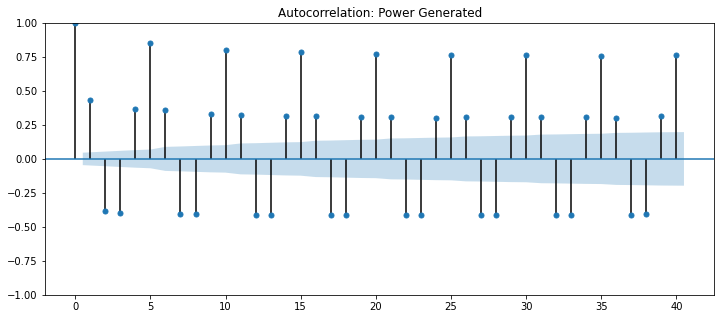

In [ ]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, ax = plt.subplots(figsize=(12,5))

acf(df['Power Generated'])
title = 'Autocorrelation: Power Generated'
lags = 40
plot_acf(df['Power Generated'],title=title,lags=lags,ax=ax);

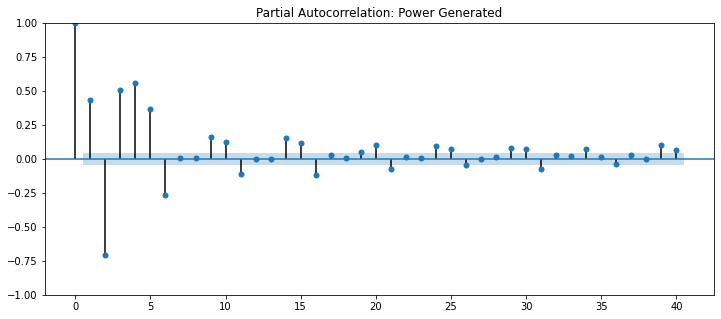

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

title='Partial Autocorrelation: Power Generated'
lags=40
plot_pacf(df['Power Generated'],title=title,lags=lags,ax=ax);

In [ ]:
from statsmodels.tsa.stattools import adfuller

#creating a report
dftest = adfuller(df['Power Generated'])
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():           #for critical value 1%, 5%, 10%
    dfout[f'critical value ({key})']=val
print(dfout)

#Our data is stationary, so seasonal component is false

ADF test statistic        -3.741219
p-value                    0.003569
# lags used               25.000000
# observations          1798.000000
critical value (1%)       -3.433992
critical value (5%)       -2.863149
critical value (10%)      -2.567626
dtype: float64


In [ ]:
from pmdarima import auto_arima

auto_arima(df['Power Generated'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1824
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -17949.366
Date:                Wed, 01 Dec 2021   AIC                          35912.732
Time:                        07:45:13   BIC                          35951.290
Sample:                             0   HQIC                         35926.956
                               - 1824                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4103      0.122     -3.354      0.001      -0.650      -0.171
ar.L2         -0.6562      0.051    -12.771      0.000      -0.757      -0.555
ar.L3         -0.6107      0.097     -6.289      0.000      -0.801      -0.420
ar.L4         -0.4118      0.085     -4.827      0.000      -0.579      -0.245
ar.L5          0.1811      0.057      3.171      0.002       0.069       0.293
ma.L1          0.1588      0.124      1.279      0.201      -0.085       0.402
sigma2      2.091e+07   9.82e-09   2.13e+15      0.000    2.09e+07    2.09e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1104.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.25
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.76e+30. Standard errors may be unstable.
"""

#AR model

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ARResults

model = AutoReg(df['Power Generated'],lags=5)
ARfit = model.fit()
ARfit.params

const                 1467.317522
Power Generated.L1       0.615297
Power Generated.L2      -0.430651
Power Generated.L3       0.054091
Power Generated.L4       0.263170
Power Generated.L5       0.365969
dtype: float64

In [ ]:
df1 = df.iloc[5:1800 , :]

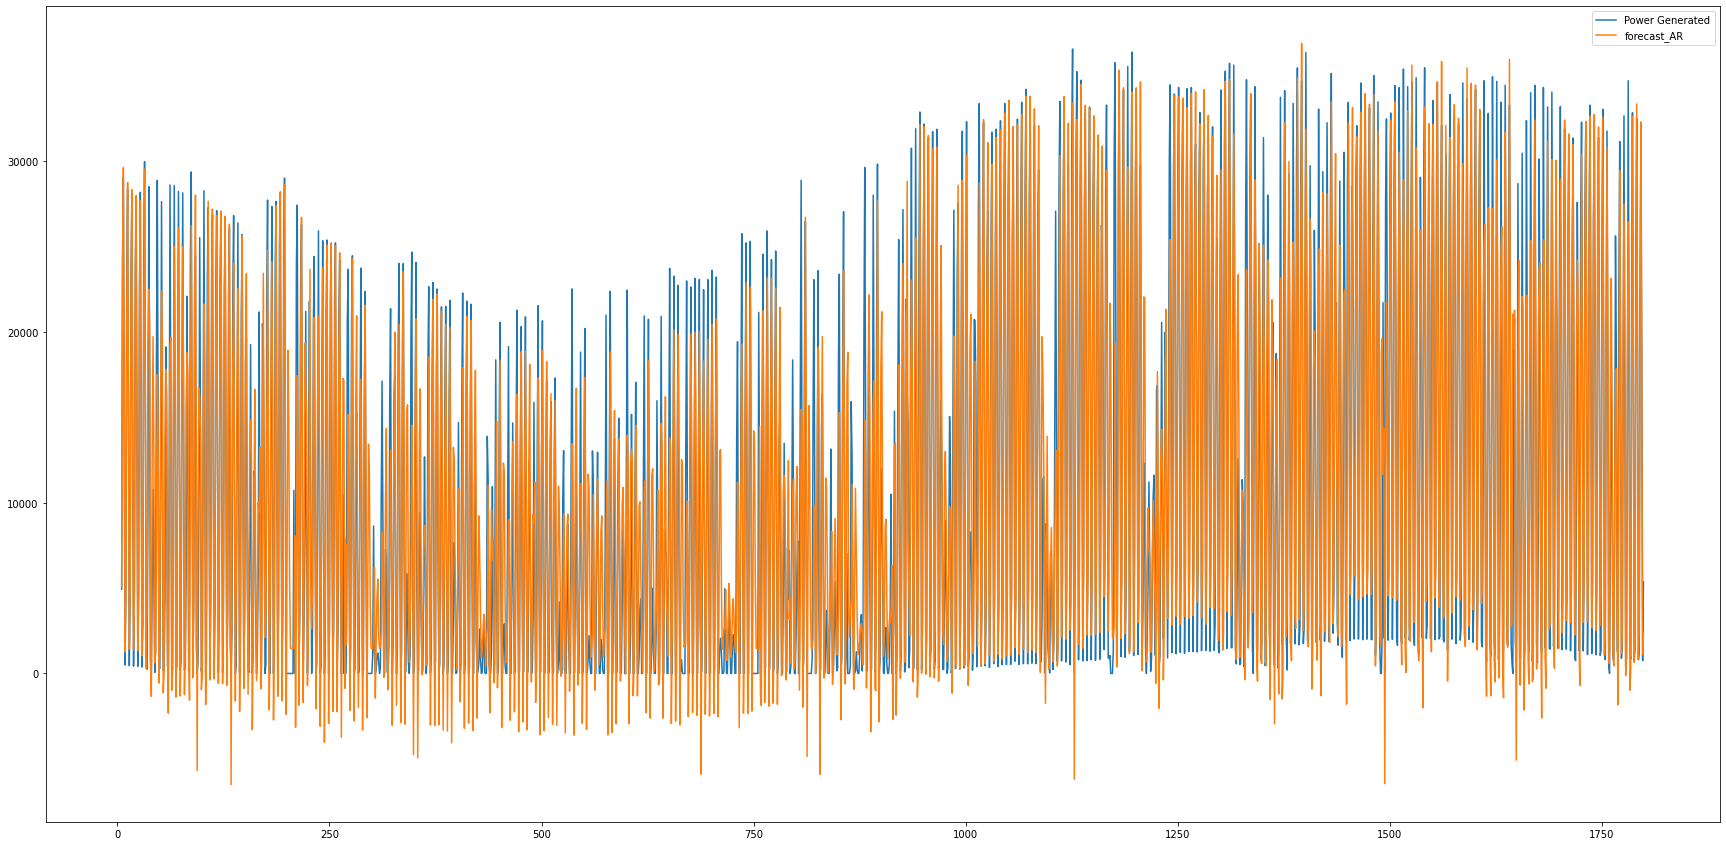

In [ ]:
df1['forecast_AR'] = ARfit.predict(start=5,end=1800)
df1[['Power Generated','forecast_AR']].plot(figsize=(30,15))

In [ ]:
rmse = np.sqrt(mean_squared_error(df1['Power Generated'] , df1['forecast_AR']))
print(rmse)
print(r2_score(df1['Power Generated'] , df1['forecast_AR']))

4649.990606567547
0.8244038528000097


#ARMA

In [ ]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm

model = sm.tsa.ARIMA(df['Power Generated'],order=(5,0,1))
ARMAfit = model.fit()
ARMAfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Power Generated   No. Observations:                 1824
Model:                 ARIMA(5, 0, 1)   Log Likelihood              -17944.612
Date:                Wed, 01 Dec 2021   AIC                          35905.224
Time:                        07:45:15   BIC                          35949.295
Sample:                             0   HQIC                         35921.482
                               - 1824                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.117e+04   1081.607     10.331      0.000    9053.879    1.33e+04
ar.L1          0.2150      0.040      5.402      0.000       0.137       0.293
ar.L2         -0.1091      0.037     -2.972      0.003      -0.181      -0.037
ar.L3         -0.1205      0.028     -4.264      0.000      -0.176      -0.065
ar.L4          0.1994      0.017     11.892      0.000       0.167       0.232
ar.L5          0.6060      0.023     25.968      0.000       0.560       0.652
ma.L1          0.4761      0.042     11.465      0.000       0.395       0.558
sigma2      2.172e+07      0.007   3.25e+09      0.000    2.17e+07    2.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):               822.02
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.07
Prob(H) (two-sided):                  0.27   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.83e+26. Standard errors may be unstable.
"""

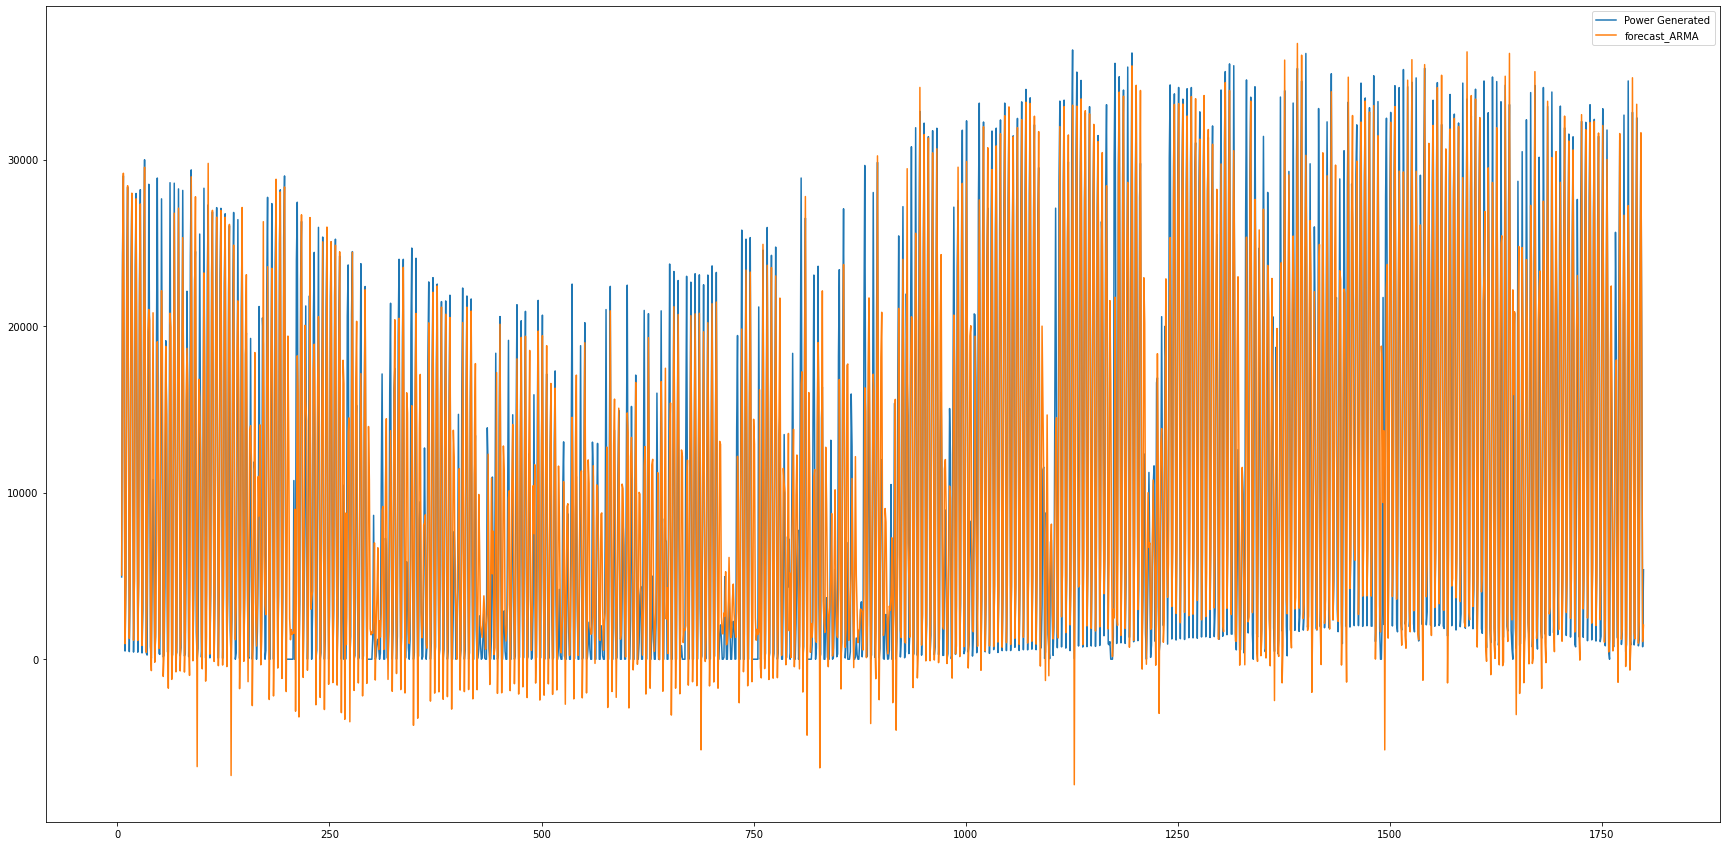

In [ ]:
df1['forecast_ARMA'] = ARMAfit.predict(start=5,end=1800)
df1[['Power Generated','forecast_ARMA']].plot(figsize=(30,15))

In [ ]:
rmse = np.sqrt(mean_squared_error(df1['Power Generated'] , df1['forecast_ARMA']))
print(rmse)
r2_score(df1['Power Generated'] , df1['forecast_ARMA'])

4514.932052040892


0.8344560669765259

#ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm

model = sm.tsa.ARIMA(df['Power Generated'],order=(5,1,1))
ARIMAfit = model.fit()
ARIMAfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Power Generated   No. Observations:                 1824
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -17949.366
Date:                Wed, 01 Dec 2021   AIC                          35912.732
Time:                        07:45:20   BIC                          35951.290
Sample:                             0   HQIC                         35926.956
                               - 1824                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4103      0.122     -3.354      0.001      -0.650      -0.171
ar.L2         -0.6562      0.051    -12.771      0.000      -0.757      -0.555
ar.L3         -0.6107      0.097     -6.289      0.000      -0.801      -0.420
ar.L4         -0.4118      0.085     -4.827      0.000      -0.579      -0.245
ar.L5          0.1811      0.057      3.171      0.002       0.069       0.293
ma.L1          0.1588      0.124      1.279      0.201      -0.085       0.402
sigma2      2.091e+07   9.82e-09   2.13e+15      0.000    2.09e+07    2.09e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1104.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.25
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.76e+30. Standard errors may be unstable.
"""

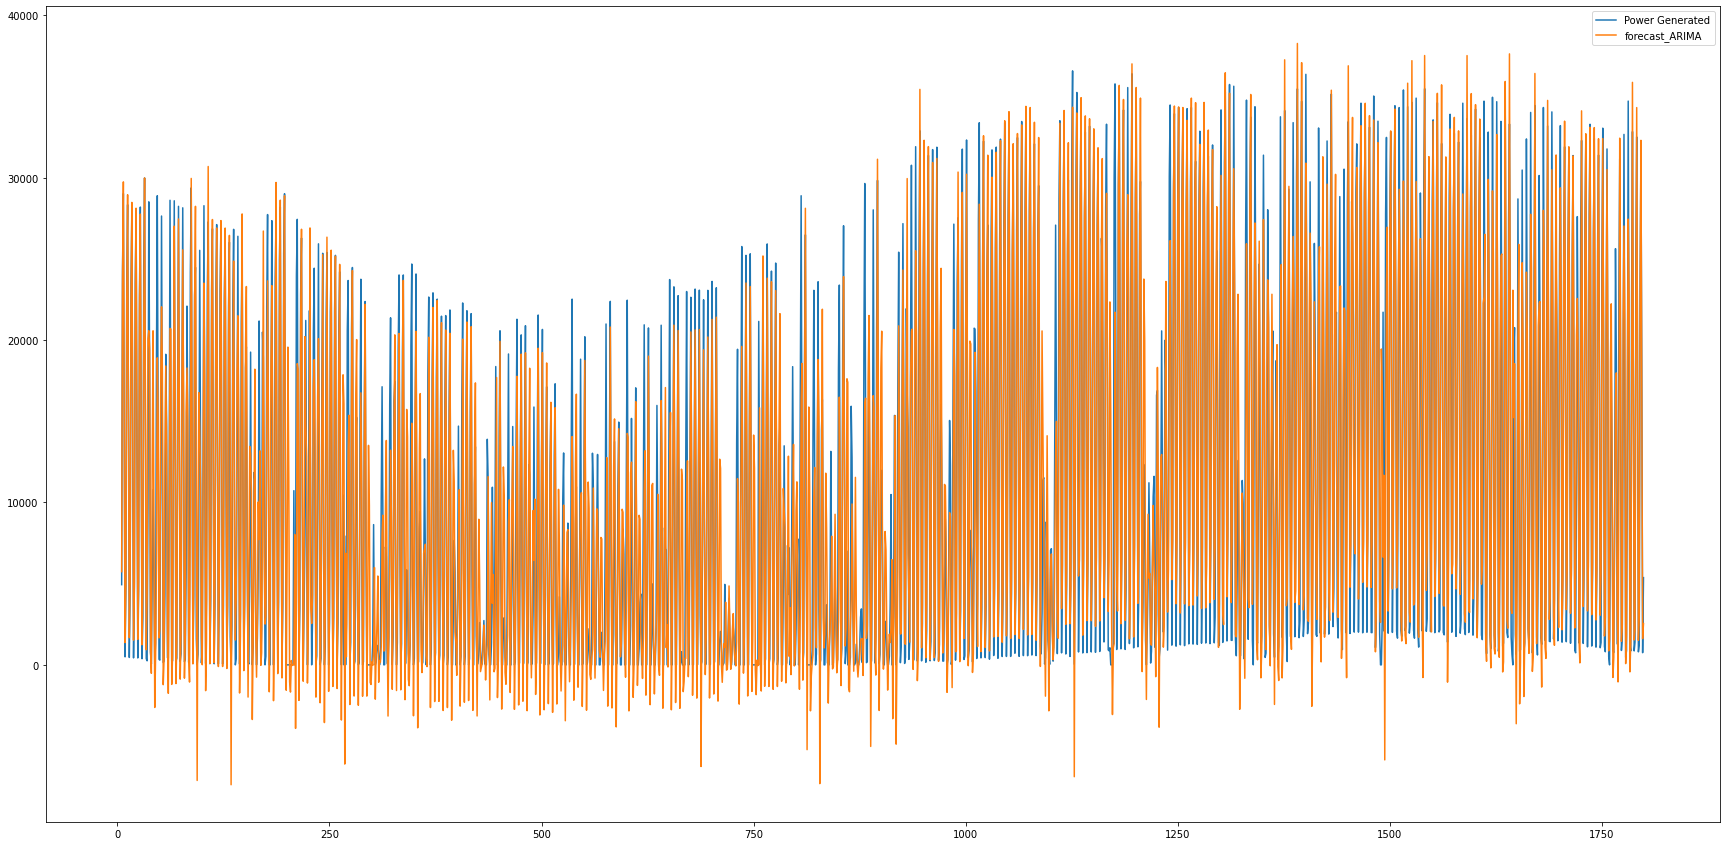

In [ ]:
df1['forecast_ARIMA'] = ARIMAfit.predict(start=5,end=1800)
df1[['Power Generated','forecast_ARIMA']].plot(figsize=(30,15))

In [ ]:
rmse = np.sqrt(mean_squared_error(df1['Power Generated'] , df1['forecast_ARIMA']))
print(rmse)
r2_score(df1['Power Generated'] , df1['forecast_ARIMA'])

4556.153429210044


0.8314194320128689

# SARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = sm.tsa.SARIMAX(df['Power Generated'],order = (1,1,1),seasonal_order = (5,1,1,5))
SARIMAfit = model.fit()
SARIMAfit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   Power Generated   No. Observations:                 1824
Model:             SARIMAX(1, 1, 1)x(5, 1, 1, 5)   Log Likelihood              -17864.353
Date:                           Wed, 01 Dec 2021   AIC                          35746.705
Time:                                   07:45:51   BIC                          35796.255
Sample:                                        0   HQIC                         35764.987
                                          - 1824                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5654      0.017     33.958      0.000       0.533       0.598
ma.L1         -0.9993      0.024    -42.395      0.000      -1.046      -0.953
ar.S.L5        0.4469      0.025     18.209      0.000       0.399       0.495
ar.S.L10       0.0866      0.028      3.134      0.002       0.032       0.141
ar.S.L15       0.1695      0.028      6.124      0.000       0.115       0.224
ar.S.L20       0.0742      0.028      2.661      0.008       0.020       0.129
ar.S.L25       0.1447      0.024      6.072      0.000       0.098       0.191
ma.S.L5       -0.9962      0.009   -106.065      0.000      -1.015      -0.978
sigma2      2.522e+07   3.93e-10   6.42e+16      0.000    2.52e+07    2.52e+07
===================================================================================
Ljung-Box (L1) (Q):                  18.81   Jarque-Bera (JB):               832.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.46
Prob(H) (two-sided):                  0.69   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.33e+30. Standard errors may be unstable.
"""

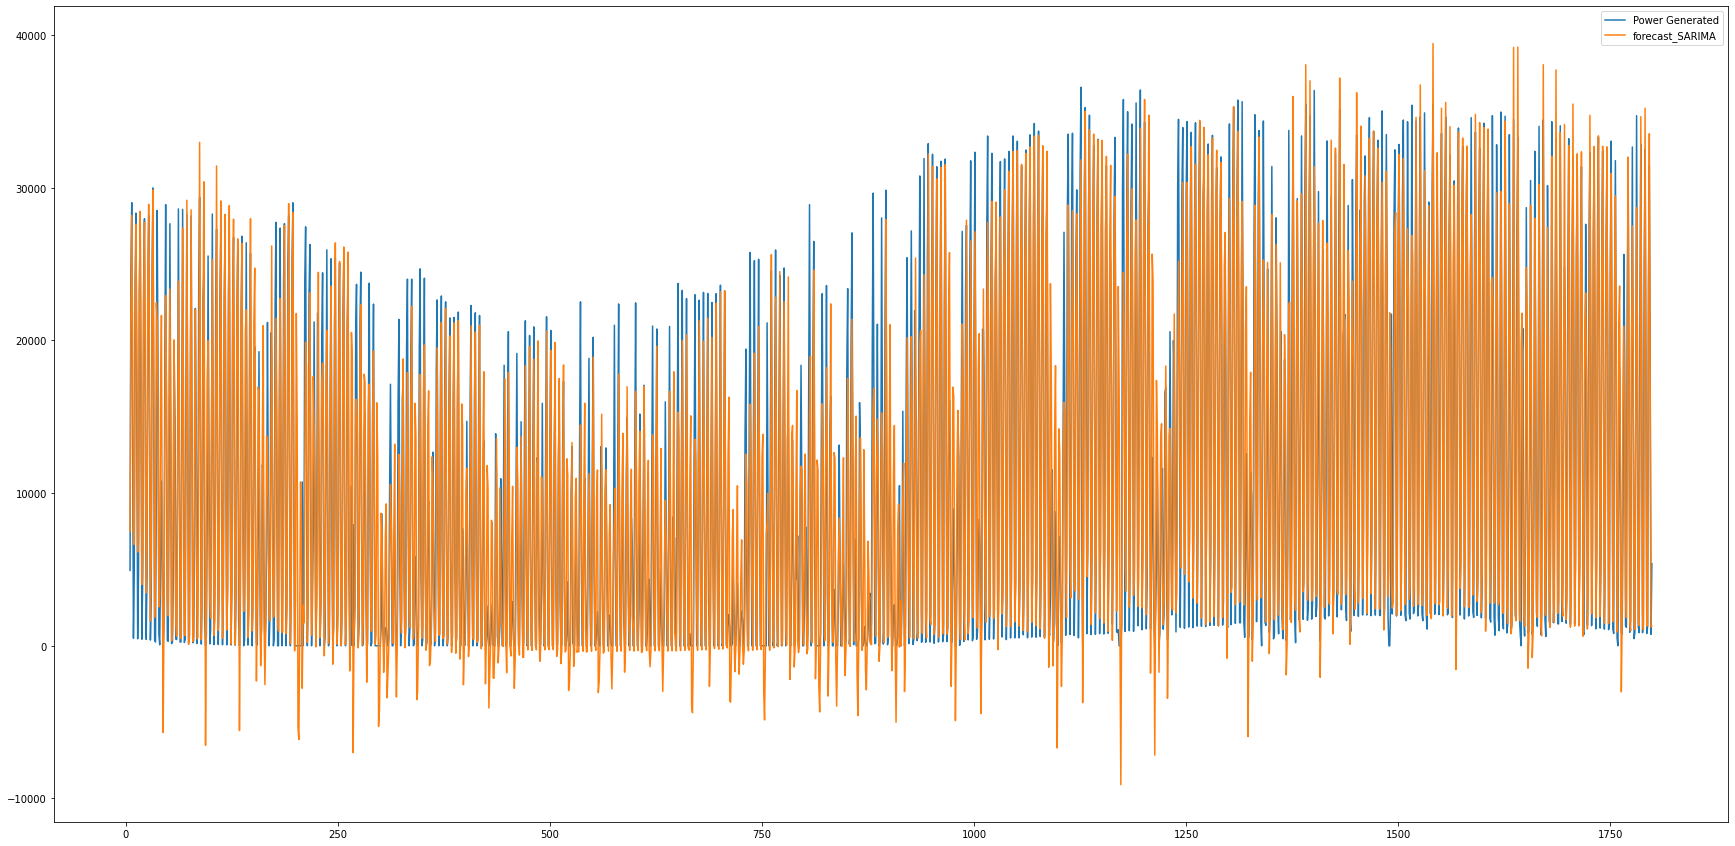

In [ ]:
df1['forecast_SARIMA']=SARIMAfit.predict(start=5,end=1800)
df1[['Power Generated','forecast_SARIMA']].plot(figsize=(30,15))

In [ ]:
rmse = np.sqrt(mean_squared_error(df1['Power Generated'] , df1['forecast_SARIMA']))
print(rmse)
r2_score(df1['Power Generated'] , df1['forecast_SARIMA'])

4391.151499167211


0.843408684169962

#Closer Look

In [ ]:
df2=df[1020:1070]
df2=df2['Power Generated']

In [ ]:
predictions1 = ARfit.predict(start=1020,end=1070)
predictions2 = ARMAfit.predict (start=1020,end=1070)
predictions3 = ARIMAfit.predict(start=1020,end=1070)
predictions4 = SARIMAfit.predict(start=1020,end=1070)

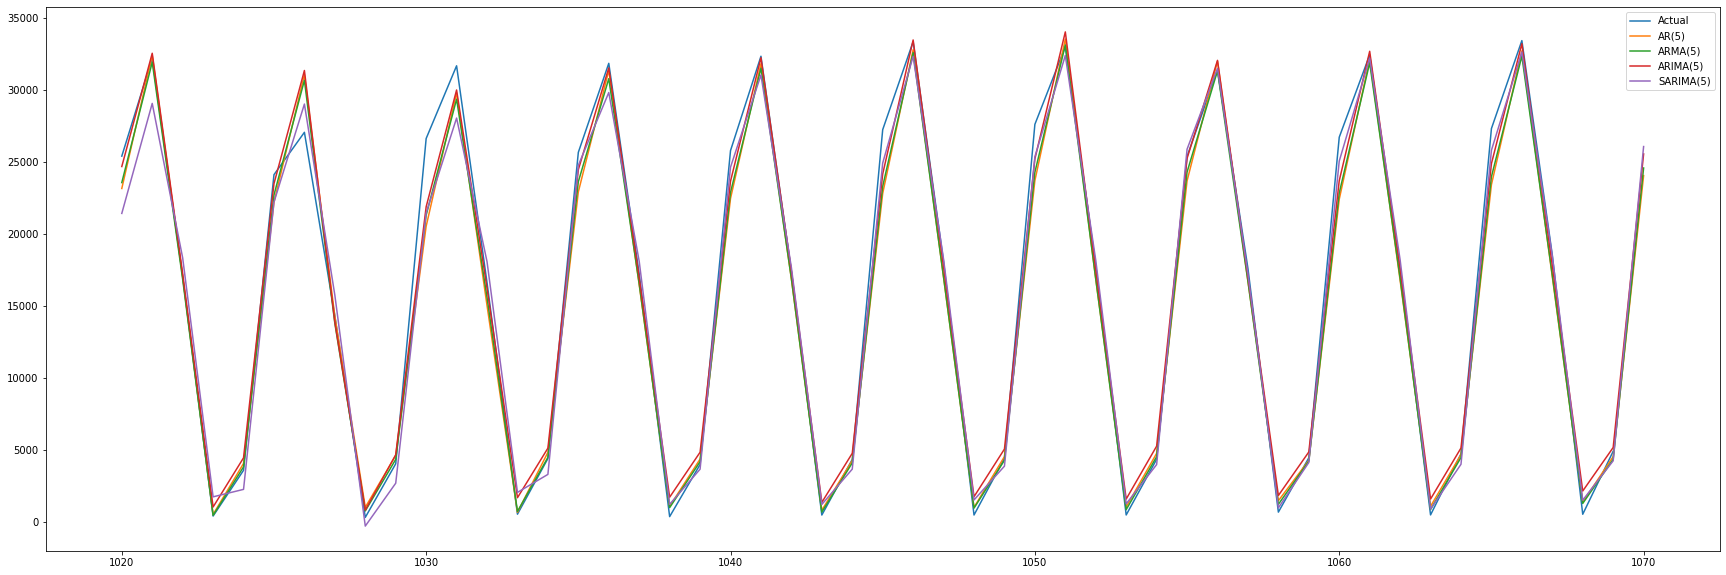

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(df2,label="Actual")
plt.plot(predictions1,label="AR(5)")
plt.plot(predictions2,label="ARMA(5)")
plt.plot(predictions3,label="ARIMA(5)")
plt.plot(predictions4,label="SARIMA(5)")
plt.legend()

Text(0.5, 0, 'Model')

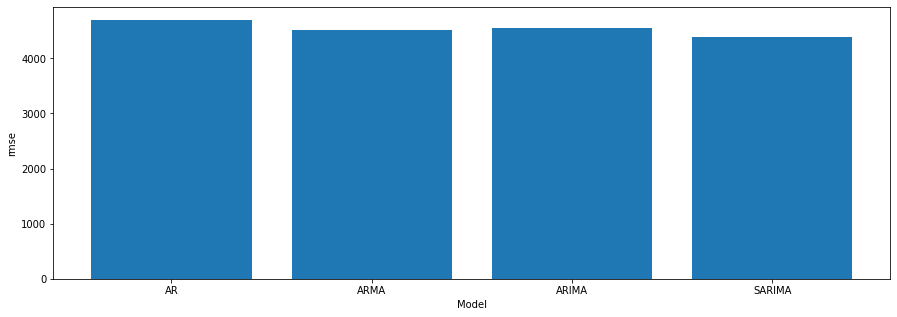

In [ ]:
import matplotlib.pyplot as plt

rmse = [4696.9906,4514.9320,4556.1534,4391.1514]
r2_score = [0.8244,0.8344,0.8314,0.8434]
time = [0.011,0.684,2.041,35.449]

x = ["AR","ARMA","ARIMA","SARIMA"]
plt.figure(figsize=(15,5))
plt.bar(x,rmse)
plt.ylabel("rmse")
plt.xlabel("Model")

Text(0.5, 0, 'Model')

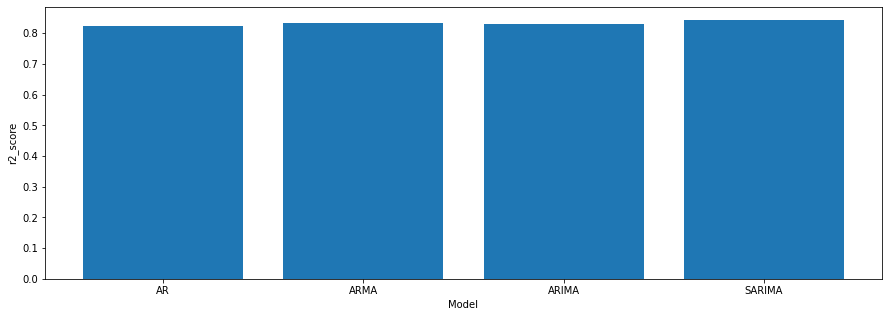

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(x,r2_score)
plt.ylabel("r2_score")
plt.xlabel("Model")

Text(0.5, 0, 'Model')

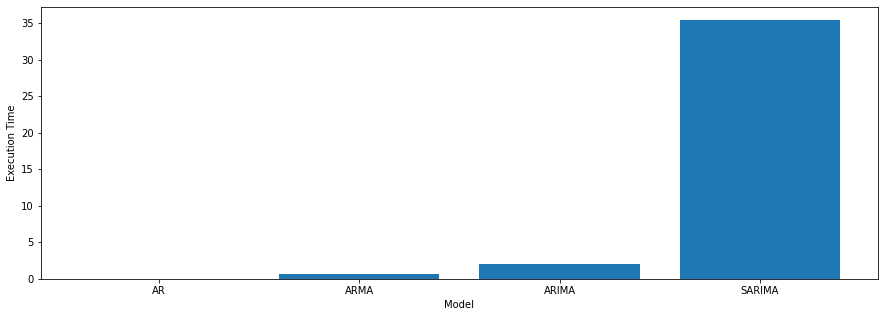

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(x,time)
plt.ylabel("Execution Time")
plt.xlabel("Model")